<a href="https://colab.research.google.com/github/KillerStrike17/Deep-Learning-for-Vision-Using-Tensorflow-Keras/blob/master/8.%20Cutout%20%26%20GradCAM/Cutouts_and_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing all the heavenly bodies
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from google.colab import drive
#Importing the database
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [0]:
#Asking Drive permission
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#splitting the database
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
#Storing the training dataset details in variables
num_train,  img_rows, img_cols,img_channels, =  train_features.shape
print("No of training dataset:- ",num_train)
print("No of rows:- ",img_rows)
print("No of columns:- ",img_cols)
print("No of channels:- ",img_channels)
#Storing the testing dataset details in variables
num_test, _, _, _ =  test_features.shape
#Storing the total class of dataset in num_classes variable
num_classes = len(np.unique(train_labels))
print("Total Classes:- ", num_classes)

170500096/170498071 [==============================] - 6s 0us/step
No of training dataset:-  50000
No of rows:-  32
No of columns:-  32
No of channels:-  3
Total Classes:-  10


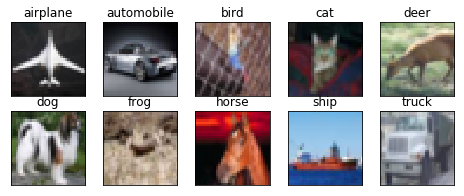

In [0]:
#class_names of the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
#loop to display a sample image of each channel
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot graphs of accuracy and loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#Function to calculate accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#converting the pixel in range 0-1
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#New Model
model = Sequential()
#(receptive field,Output Channel) calculated using old method
model.add(Convolution2D(32, 3, 3, border_mode='same', activation = 'relu', input_shape=(32, 32, 3)))
#(3,32)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(60, 3, 3, activation = 'relu'))
#(5,30)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(70, 3, 3, border_mode='same', activation = 'relu'))
#(7,30)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))
#(14,15)
model.add(Convolution2D(32, 1, 1, activation = 'relu'))
#(14,15)
model.add(Convolution2D(60, 3, 3, activation = 'relu'))
#(16,13)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(70, 3, 3, border_mode='same', activation = 'relu'))
#(18,13)
model.add(BatchNormalization())
model.add(Dropout(0.25))

#model.add(MaxPooling2D(pool_size=(2, 2)))
#(36,6)
model.add(Convolution2D(32, 1, 1, activation = 'relu'))
#(36,6)
model.add(Convolution2D(60, 3, 3, activation = 'relu'))
#(38,4)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(70, 3, 3, border_mode='same', activation = 'relu'))
#(40,4)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(70, 3, 3, border_mode='same', activation = 'relu'))
#(40,4)
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(10, 1, 1, activation = 'relu'))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Activation('softmax'))

model.summary()

W0808 16:19:54.933324 139829395646336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0808 16:19:54.977506 139829395646336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 16:19:54.986295 139829395646336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 60)        17340     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 60)        240       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 70)        37870     
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(70, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu")`


W0808 16:20:01.631463 139829395646336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 16:20:01.774666 139829395646336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
196/196 [==============================] - 43s 219ms/step - loss: 1.4458 - acc: 0.4707 - val_loss: 1.7125 - val_acc: 0.5014

Epoch 00001: val_acc improved from -inf to 0.50140, saving model to weights-improvement-01-0.50.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
196/196 [==============================] - 36s 186ms/step - loss: 1.0268 - acc: 0.6324 - val_loss: 1.0710 - val_acc: 0.6423

Epoch 00002: val_acc improved from 0.50140 to 0.64230, saving model to weights-improvement-02-0.64.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
196/196 [==============================] - 37s 187ms/step - loss: 0.8680 - acc: 0.6910 - val_loss: 0.9499 - val_acc: 0.6731

Epoch 00003: val_acc improved from 0.64230 to 0.67310, saving model to weights-improvement-03-0.67.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learni

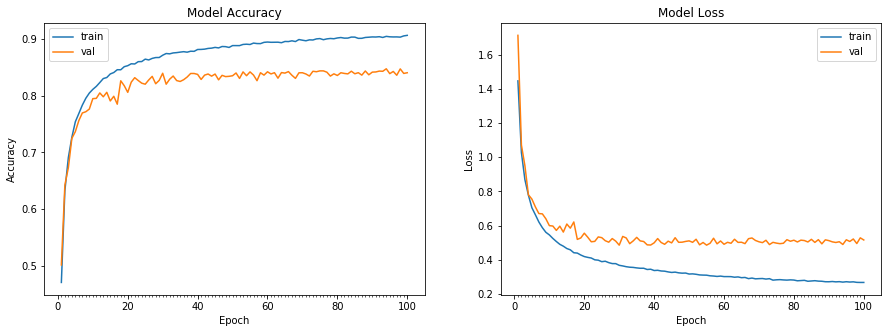

Accuracy on test data is: 32.68


In [0]:
#compiling and training the model
#Learning Rate scheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

#Compiling the model
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
validation_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

datagen.fit(train_features)
validation_datagen.fit(train_features)

train_iterator = datagen.flow(train_features, train_labels, batch_size=256,shuffle=True)
validation_iterator = validation_datagen.flow(test_features, test_labels, batch_size=256,shuffle=True)
                                              
# train the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
start = time.time()
                                              
# Train the model
model_info = model.fit_generator(train_iterator,
                      steps_per_epoch=len(train_iterator), 
                      validation_data = validation_iterator, 
                      validation_steps = len(validation_iterator),
                      epochs=100, verbose=1,
                      callbacks = [checkpoint,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
#Saving the Developed Model to Google Drive
model.save("/content/gdrive/My Drive/My Models/Session9-GradCAM-model.h5")

# Cutout Visualization


In [0]:
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img

    return eraser
  
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
def show_examples(X, y_ohe, classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y_ohe[idx])])
    plt.show()

def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

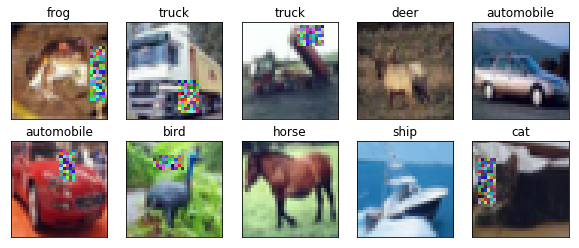

In [0]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, 
                                                                      max_erasures_per_image=1, pixel_level=True))
datagen.fit(train_features)
train_iterator = datagen.flow(train_features, train_labels, batch_size=100,shuffle=False)

X, Y = train_iterator.next()
X = min_max_scale(X)
show_examples(X[0:10], Y[0:10], classes = get_cifar10_labels())


In [0]:
import cv2
from keras.preprocessing import image

#return the gradCAM heatmap - gradCAm algorithm
#gradCam function to generate heatmaps
def gradCam(imageID, model, layer): 
  
  class_idx = np.argmax(preds[imageID])
  class_output = model.output[:, class_idx]

  #get the last convolutional layer
  last_conv_layer = model.get_layer(layer)
  layer_out_channels = last_conv_layer.output_shape[-1]
  
  #get the gradients of the last layer
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  
  #pool the gradients over all the axes
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  testImage = test_features[imageID]
  testImage = testImage.reshape(1,32,32,3)
  pooled_grads_value, conv_layer_output_value = iterate([testImage])

  for i in range(layer_out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  img = test_features[imageID]

  #build a heatmap 
  
  #average the weighted feature map
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  #RELU
  heatmap = np.maximum(heatmap, 0)
  #normalize between 0 and 1
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


  heatmap = heatmap/255
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
        heatmap[i][j] = 0
        
  img = (img - np.min(img))/(np.max(img)-np.min(img))
  #superimpose the heatmap over original image
  superimposed_img = 0.65*(img) + 0.35*heatmap
  
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if np.sum(heatmap[i][j])==0:
        superimposed_img[i][j]=img[i][j]
  
  #return the superimposed iaage  
  return superimposed_img

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
500/500 [==============================] - 50s 99ms/step - loss: 0.8535 - acc: 0.7057 - val_loss: 0.9270 - val_acc: 0.7145
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
500/500 [==============================] - 49s 98ms/step - loss: 0.6567 - acc: 0.7704 - val_loss: 0.8249 - val_acc: 0.7198
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
500/500 [==============================] - 49s 98ms/step - loss: 0.5949 - acc: 0.7931 - val_loss: 0.5780 - val_acc: 0.7968
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
500/500 [==============================] - 49s 98ms/step - loss: 0.5602 - acc: 0.8050 - val_loss: 0.5913 - val_acc: 0.7991
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
500/500 [==============================] - 49s 98ms/step - loss: 0.5315 - acc: 0

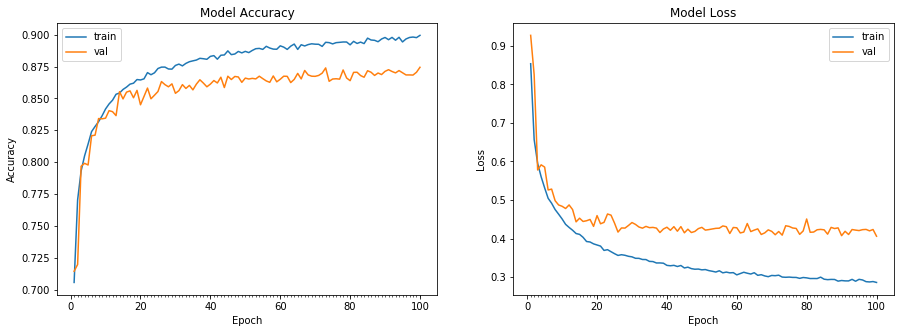

Accuracy on test data is: 35.38


In [0]:
#Learning Rate scheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)


datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, 
                                                                      max_erasures_per_image=1, pixel_level=True))
datagen.fit(train_features)

start = time.time()
checkpoint = ModelCheckpoint('weights-improvement-cutouts-{epoch:02d}-{val_acc:.2f}.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# Train the model
model_info = model.fit_generator(train_iterator,
                      steps_per_epoch=len(train_iterator), 
                      validation_data = validation_iterator, 
                      validation_steps = len(validation_iterator),
                      epochs=100, verbose=1,
                      callbacks = [checkpoint,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
#Saving the Developed Model to Google Drive
model.save("/content/gdrive/My Drive/My Models/Session9-GradCAMWithCutout-model.h5")

In [0]:
#load the model without cutout
model = load_model('/content/gdrive/My Drive/My Models/Session9-GradCAM-model.h5')
#load the model with cutout
model2 = load_model('/content/gdrive/My Drive/My Models/Session9-GradCAMWithCutout-model.h5')

In [0]:
iterator = validation_datagen.flow(test_features, test_labels, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = validation_datagen.flow(test_features, test_labels, batch_size=256, shuffle=False)
score2 = model2.evaluate_generator(iterator,steps=len(iterator))
#predictions = model.predict_generator(iterator,steps=len(iterator))
print("Score:- ",score)
print("Score 2:-",score2)

Score:-  [0.5152808876037598, 0.8406]
Score 2:- [0.41634101037979127, 0.8711]


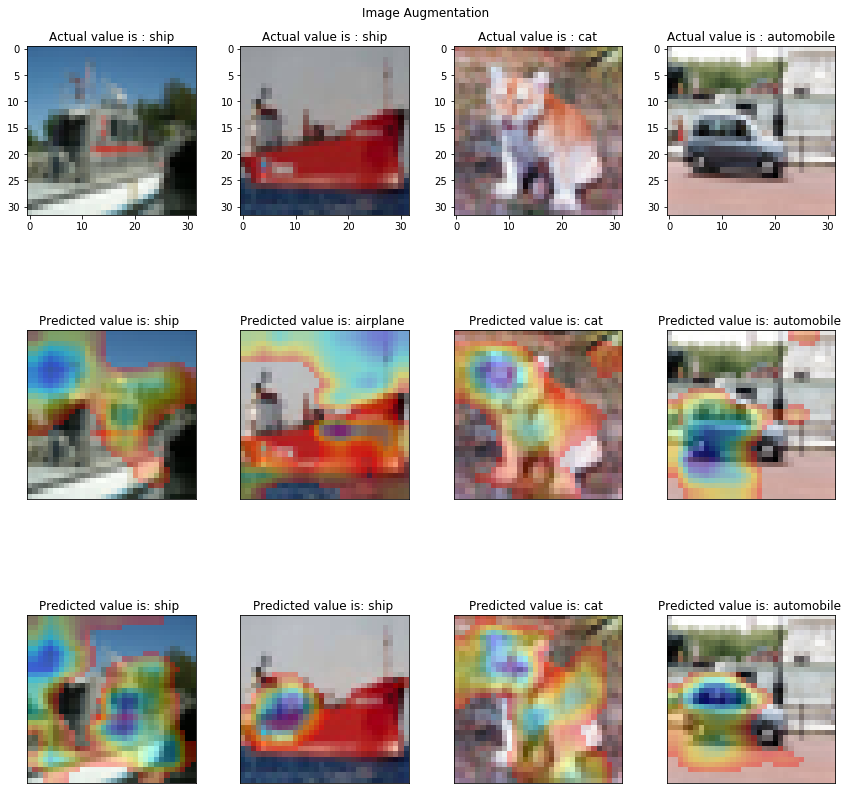

In [0]:
from google.colab.patches import cv2_imshow
from keras.models import load_model
from keras import backend as K

#imageIds = [600,9000,5000,7000]
imageIds = [600,5002,7310,8123]
imageIds = [1,12,123,1234]
#from a subplot of 5X5 images with each figure of 20X20
fig, ax = plt.subplots(3, 4, figsize = (12, 12))
  
fig.tight_layout()
#give title to sub plot
fig.suptitle('Image Augmentation')


#plot the original image
for i in range(len(imageIds)):
  #show the image
  ax[0,i].imshow(test_features[imageIds[i]])
  ax[0,i].set_title('Actual value is : %s' %(class_names[np.argmax(test_labels[imageIds[i]])]))



#for all the images print the heatmap of model w/o cutout

preds = model.predict(test_features)

for i in range(len(imageIds)):
  #get b,g,r
     
  #img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  #uperimposed_img = gradCam(imageIds[i], model)
  #superimposed_img = cv2.resize(superimposed_img, dsize=(20, 20), interpolation=cv2.INTER_CUBIC)
  #cv2_imshow(superimposed_img)
  #show the image
  ax[1,i].set_xticks([])
  ax[1,i].set_yticks([])
  ax[1,i].imshow(gradCam(imageIds[i], model, "conv2d_11"))
  
  #set the title of the image
  ax[1,i].set_title('Predicted value is: %s ' %(class_names[np.argmax(preds[imageIds[i]])]))

  
#for all the images print the heatmap of model w cutout

preds = model2.predict(test_features)

for i in range(len(imageIds)):
  #show the image
  superimposed_img = gradCam(imageIds[i], model,"conv2d_11")
  superimposed_img = cv2.resize(superimposed_img, dsize=(20, 20), interpolation=cv2.INTER_CUBIC)
  cv2_imshow(superimposed_img)
  #show the image
  ax[2,i].imshow(gradCam(imageIds[i], model2, "conv2d_11"))
  ax[2,i].set_xticks([])
  ax[2,i].set_yticks([])
  #set the title of the image
  ax[2,i].set_title('Predicted value is: %s ' %(class_names[np.argmax(preds[imageIds[i]])]))
  
